In [1]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [71]:
from datasets import load_dataset, DatasetDict
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,T5ForConditionalGeneration
from pprint import pprint
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from collections import Counter


In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

In [4]:
dataset = load_dataset("b-mc2/sql-create-context")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 78577
    })
})

In [42]:
input_a = [a + b for a, b in zip(dataset['train']['context'],dataset['train']['question'])]
#np.histogram(np.unique([len(ii) for ii in dataset['train']['question']])),np.histogram(np.unique([len(ii) for ii in dataset['train']['answer']])),\
#np.histogram(np.unique([len(ii) for ii in a]))
#add 19 to each for the prefixes
np.histogram(([len(ii) for ii in input_a]))[0],np.histogram(([len(ii) for ii in input_a]))[1]+19

(array([14402, 44139, 15210,  3680,   829,   233,    63,    15,     4,
            2]),
 array([ 71. , 119.6, 168.2, 216.8, 265.4, 314. , 362.6, 411.2, 459.8,
        508.4, 557. ]))

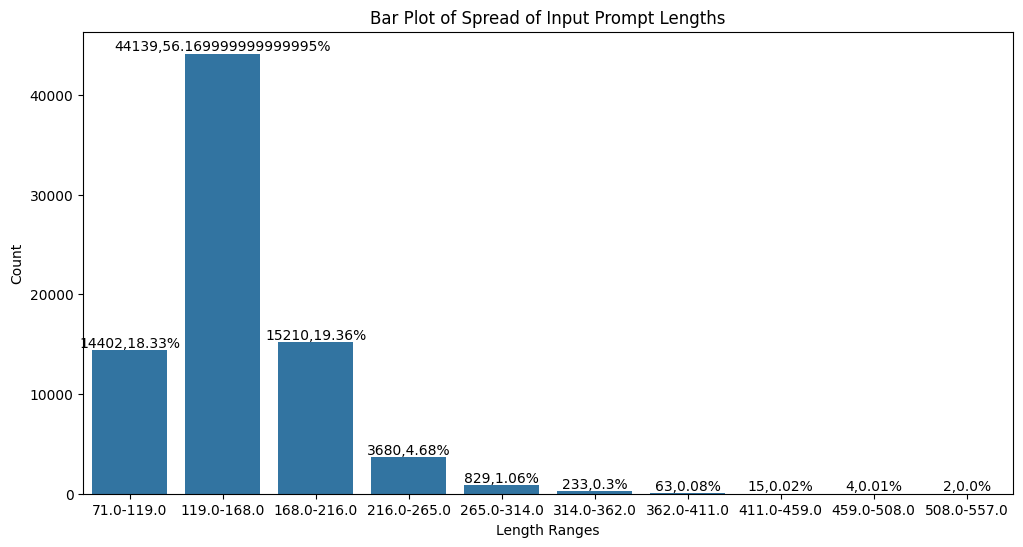

In [43]:
lengths = [ 71. , 119.6, 168.2, 216.8, 265.4, 314. , 362.6, 411.2, 459.8,
        508.4, 557. ]
length_ranges = [f"{np.floor(a)}-{np.floor(b)}" for a, b in zip(lengths, lengths[1:])]

values = [14402, 44139, 15210,  3680,   829,   233,    63,    15,     4,
            2]

df = pd.DataFrame({
    'Lengths': length_ranges,  # Create a category for each value
    'Count': values
})

plt.figure(figsize=(12, 6))  # Width of 12 inches and height of 6 inches

ax = sns.barplot(x='Lengths', y='Count', data=df)

plt.xlabel('Length Ranges')
plt.ylabel('Count')
plt.title('Bar Plot of Spread of Input Prompt Lengths')

for p in ax.patches:
    # Calculate annotation text and position
    text = f'{int(p.get_height())}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    # Add text annotation
    ax.text(x, y, text+f',{100 * round((y/78577),4)}%', ha='center', va='bottom')


plt.show()

In [41]:
#99% input sequence length is less than 310.     99.4% less than 362.  perhaps set it equal to 460 to save compute.
#6 only are more than this.   it might still be enough to learn from it.  some of answer would get cut off.  perhaps drop it.  it can only harm it.

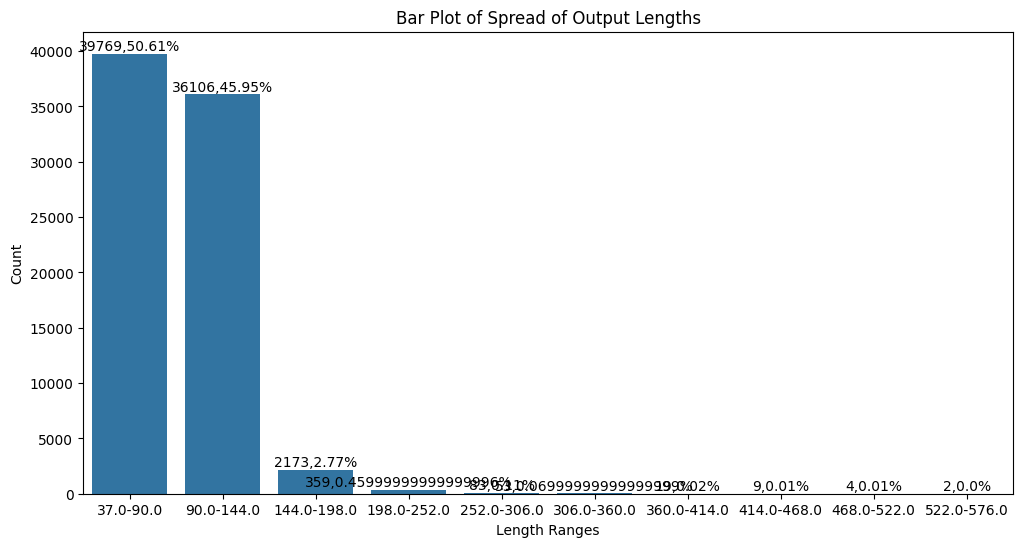

In [75]:
label_a = dataset['train']['answer']
#np.histogram(np.unique([len(ii) for ii in dataset['train']['question']])),np.histogram(np.unique([len(ii) for ii in dataset['train']['answer']])),\
#np.histogram(np.unique([len(ii) for ii in a]))
#add 19 to each for the prefixes

lengths = np.histogram(([len(ii) for ii in label_a]))[1]+19
length_ranges = [f"{np.floor(a)}-{np.floor(b)}" for a, b in zip(lengths, lengths[1:])]

values = np.histogram(([len(ii) for ii in label_a]))[0]

# Convert your data into a DataFrame
df = pd.DataFrame({
    'Lengths': length_ranges,  # Create a category for each value
    'Count': values
})

plt.figure(figsize=(12, 6))  # Width of 12 inches and height of 6 inches

# Create a bar plot using Seaborn and capture the Axes object
ax = sns.barplot(x='Lengths', y='Count', data=df)

# Adding labels for clarity (optional)
plt.xlabel('Length Ranges')
plt.ylabel('Count')
plt.title('Bar Plot of Spread of Output Lengths')

for p in ax.patches:
    # Calculate annotation text and position
    text = f'{int(p.get_height())}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    # Add text annotation
    ax.text(x, y, text+f',{100 * round((y/78577),4)}%', ha='center', va='bottom')


plt.show()

In [47]:
#set to 400 for answers

In [50]:

dataset['train']['context']

['CREATE TABLE head (age INTEGER)',
 'CREATE TABLE head (name VARCHAR, born_state VARCHAR, age VARCHAR)',
 'CREATE TABLE department (creation VARCHAR, name VARCHAR, budget_in_billions VARCHAR)',
 'CREATE TABLE department (budget_in_billions INTEGER)',
 'CREATE TABLE department (num_employees INTEGER, ranking INTEGER)',
 'CREATE TABLE head (name VARCHAR, born_state VARCHAR)',
 'CREATE TABLE department (creation VARCHAR, department_id VARCHAR); CREATE TABLE management (department_id VARCHAR, head_id VARCHAR); CREATE TABLE head (head_id VARCHAR, born_state VARCHAR)',
 'CREATE TABLE head (born_state VARCHAR)',
 'CREATE TABLE department (creation VARCHAR)',
 'CREATE TABLE management (department_id VARCHAR, temporary_acting VARCHAR); CREATE TABLE department (name VARCHAR, num_employees VARCHAR, department_id VARCHAR)',
 'CREATE TABLE management (temporary_acting VARCHAR)',
 'CREATE TABLE management (department_id VARCHAR); CREATE TABLE department (department_id VARCHAR)',
 'CREATE TABLE head

In [55]:
import re
from collections import Counter

# Example SQL queries
sql_queries = dataset['train']['answer']


# Define keywords/clauses to search for
keywords = ['SELECT', 'LEFT', 'CROSS', 'WITH','ORDER','LIMIT', 'AND', 'OR','LIKE','%','BETWEEN', 'OUTER', 'JOIN', 'WHERE', 'GROUP BY', 'HAVING']

# Initialize a counter for each keyword
keyword_counts = Counter({keyword: 0 for keyword in keywords})

# Compile a regex pattern for each keyword (assuming keywords are whole words)
patterns = {keyword: re.compile(r'\b' + keyword + r'\b', re.IGNORECASE) for keyword in keywords}

# Search for each keyword in each query and update counts
for query in sql_queries:
    for keyword, pattern in patterns.items():
        if pattern.search(query):
            keyword_counts[keyword] += 1

sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)

# Display the counts
for keyword, count in sorted_keyword_counts:
    print(f"{keyword}: {count}")


SELECT: 78577
WHERE: 75675
AND: 22585
JOIN: 1789
GROUP BY: 1160
ORDER: 1101
LIMIT: 731
HAVING: 292
OR: 195
WITH: 121
LIKE: 104
LEFT: 50
BETWEEN: 47
CROSS: 13
OUTER: 4
%: 0


In [63]:
import re
from collections import Counter

# Example SQL queries
sql_queries = dataset['train']['context']


# Define keywords/clauses to search for
keywords = ['VARCHAR', 'CREATE TABLE','INT','TEXT', 'UPDATE', 'INSERT', 'DELETE', 'REMOVE', 'ALTER']

# Initialize a counter for each keyword
keyword_counts = Counter({keyword: 0 for keyword in keywords})

# Compile a regex pattern for each keyword (assuming keywords are whole words)
patterns = {keyword: re.compile(r'\b' + keyword + r'\b', re.IGNORECASE) for keyword in keywords}

# Search for each keyword in each query and update counts
for query in sql_queries:
    for keyword, pattern in patterns.items():
        if pattern.search(query):
            keyword_counts[keyword] += 1


sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)

# Display the counts
for keyword, count in sorted_keyword_counts:
    print(f"{keyword}: {count}")

CREATE TABLE: 78577
VARCHAR: 76857
TEXT: 7
INT: 4
UPDATE: 0
INSERT: 0
DELETE: 0
REMOVE: 0
ALTER: 0


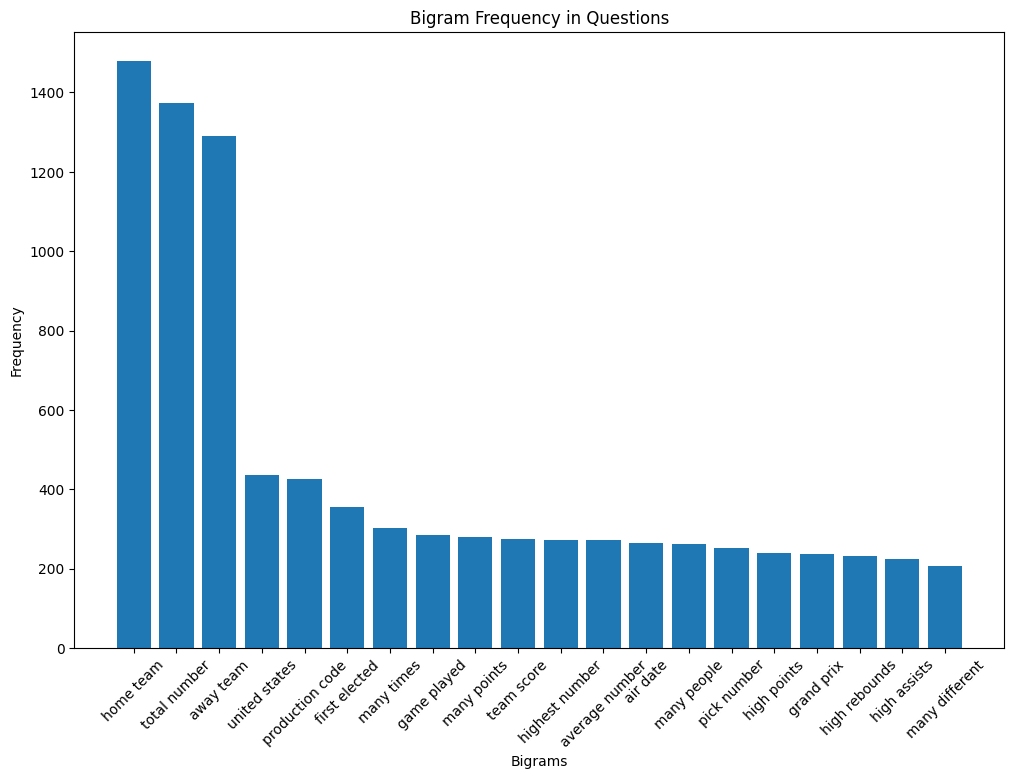

['SELECT COUNT(*) FROM head WHERE age > 56How many heads of the departments are older than 56 ?',
 'SELECT name, born_state, age FROM head ORDER BY ageList the name, born state and age of the heads of departments ordered by age.',
 'SELECT creation, name, budget_in_billions FROM departmentList the creation year, name and budget of each department.',
 'SELECT MAX(budget_in_billions), MIN(budget_in_billions) FROM departmentWhat are the maximum and minimum budget of the departments?',
 'SELECT AVG(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15What is the average number of employees of the departments whose rank is between 10 and 15?',
 "SELECT name FROM head WHERE born_state <> 'California'What are the names of the heads who are born outside the California state?",
 "SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id = T2.department_id JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T3.born_state = 'Alabama'What are the distinct cr

In [73]:

# Download necessary NLTK data
#nltk.download('punkt')
#nltk.download('stopwords')

# Assuming 'questions' is your list of questions
# questions = dataset['train']['question']

# Generate bigrams and filter stopwords
stop_words = set(stopwords.words('english'))
filtered_bigrams = [
    (w1.lower(), w2.lower())
    for question in questions
    for w1, w2 in bigrams(word_tokenize(question))
    if w1.isalpha() and w2.isalpha() and w1.lower() not in stop_words and w2.lower() not in stop_words
]

# Count the frequency of each bigram
bigram_counts = Counter(filtered_bigrams)

# Sort bigrams by frequency
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)

# Unzip the bigrams and their frequencies
bigrams, frequencies = zip(*sorted_bigrams)

# Convert bigram tuples to strings for plotting
bigram_strings = [' '.join(bigram) for bigram in bigrams]

# Plotting
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
plt.bar(bigram_strings[:20], frequencies[:20])  # Plotting top 20 bigrams for readability
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the bigrams on the x-axis to make them readable
plt.title('Bigram Frequency in Questions')
plt.show()


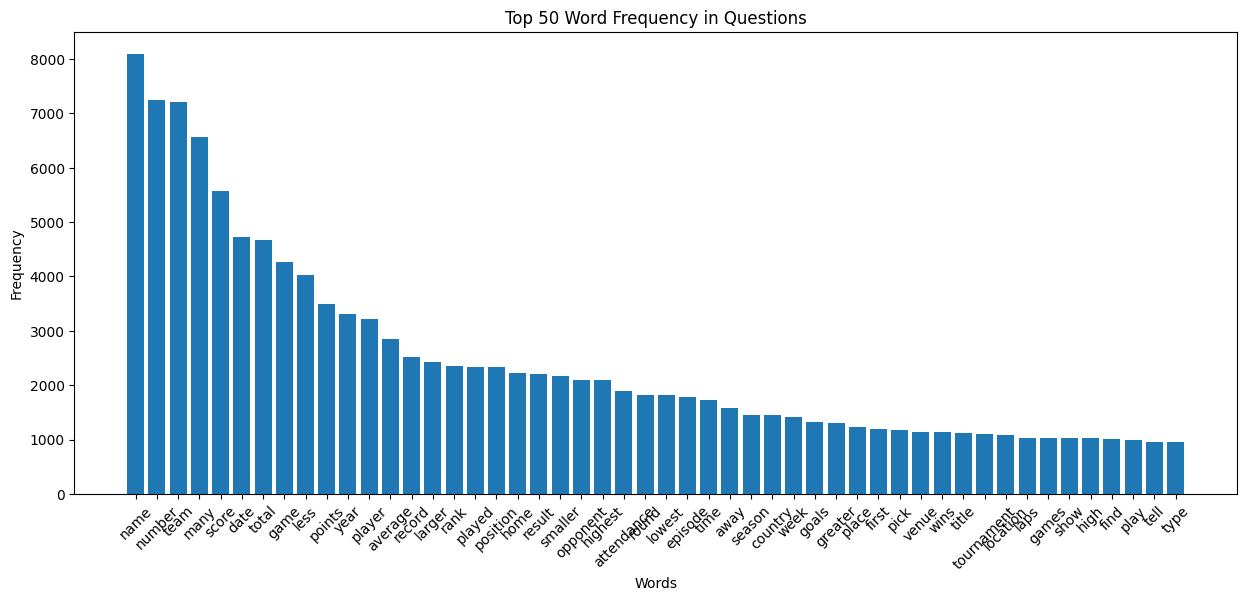

In [69]:
# Plotting
plt.figure(figsize=(15, 6))  # Optional: Adjust the figure size as needed
plt.bar(words[:50], frequencies[:50])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the words on the x-axis to make them readable
plt.title('Top 50 Word Frequency in Questions')
plt.show()


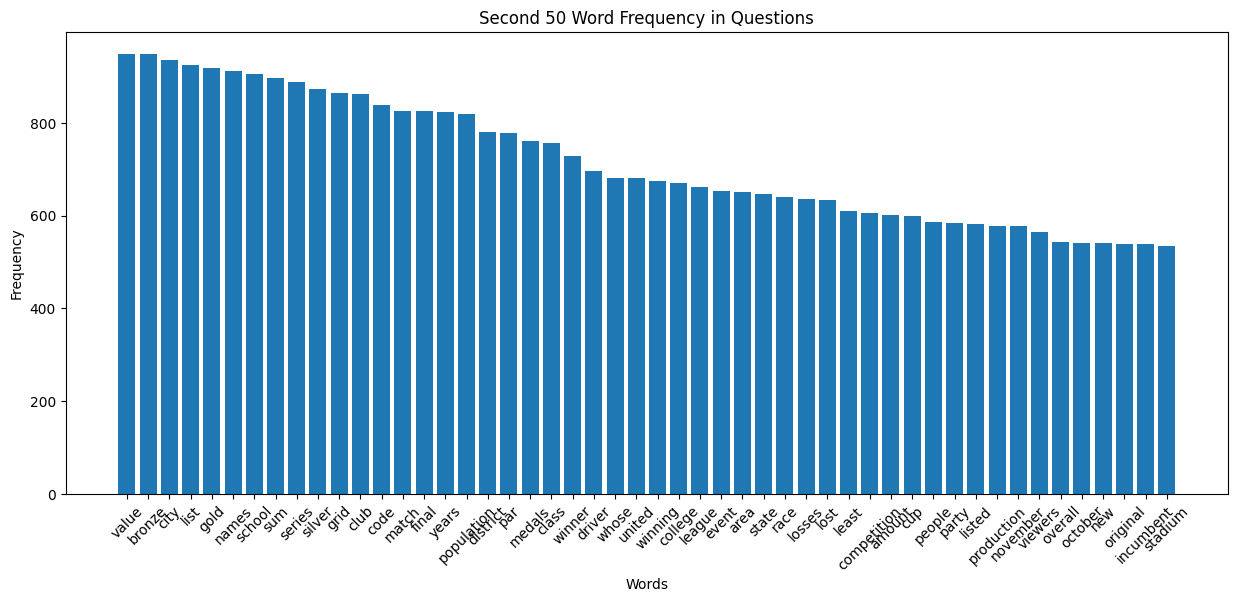

In [70]:
# Plotting
plt.figure(figsize=(15, 6))  # Optional: Adjust the figure size as needed
plt.bar(words[50:100], frequencies[50:100])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the words on the x-axis to make them readable
plt.title('Second 50 Word Frequency in Questions')
plt.show()